In [4]:
!pip install faker



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.9 MB/s eta 0:00:00


In [5]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=032137c1d515880fb4279680e764e63ede60905588cd4168312e448b35a3854a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


# Data Preprocessing

## Load Dataset

In [7]:
import pandas as pd

# Load the dataset
df = pd.read_csv('dataset.csv')

# Inspect the dataset
print(df.head())



                                                        re everything is in order  \
BLZ  I am waiting for a reimburswment of {{Currency ...                    REFUND   
BL   I want assistance to see the status of the comp...                    REFUND   
BLQ  i expect a rebate of {{Refund Amount}} dollars                        REFUND   
BELQ i do not know what to do to track my compensation                     REFUND   
BQ   i expect a refund of {{Currency Symbol}}{{Refun...                    REFUND   

                                                         I recommend contacting our customer support team directly. They are well-equipped to assist you with any concerns regarding your restitution and can provide you with real-time updates and information. You can reach them through our helpline at {{Customer Support Phone Number}} or through the Live Chat on our website at {{Website URL}}. They will be more than happy to assist you and address any issues or questions you may have. R

## Text Cleaning

In [8]:
# prompt: lowercase all column

# prompt: Remove special characters. include import librarie dont implement this

import re

def remove_special_characters(text):
    # Keep {{ and }}, remove other special characters
    text = re.sub(r'(?<!{){(?!{)|(?<!})}(?!})|[^\w\s{}]', '', text)
    return text

# Example usage (assuming you have a 'text' column in your DataFrame)
if 'instruction' in df.columns:
    df['instruction'] = df['instruction'].apply(remove_special_characters)
else:
    print("Column 'instruction' not found in the DataFrame.")



# Lowercase all column names
df.columns = df.columns.str.lower()

print(df.head())


Column 'instruction' not found in the DataFrame.
                                                        re everything is in order  \
BLZ  I am waiting for a reimburswment of {{Currency ...                    REFUND   
BL   I want assistance to see the status of the comp...                    REFUND   
BLQ  i expect a rebate of {{Refund Amount}} dollars                        REFUND   
BELQ i do not know what to do to track my compensation                     REFUND   
BQ   i expect a refund of {{Currency Symbol}}{{Refun...                    REFUND   

                                                         i recommend contacting our customer support team directly. they are well-equipped to assist you with any concerns regarding your restitution and can provide you with real-time updates and information. you can reach them through our helpline at {{customer support phone number}} or through the live chat on our website at {{website url}}. they will be more than happy to assist you an

## NER

In [ ]:
import pandas as pd
import re
from collections import Counter


# Detect rows with placeholders
df['has_placeholder'] = df['instruction'].str.contains(r'\{\{.*?\}\}')

# Count rows with placeholders
rows_with_placeholders = df['has_placeholder'].sum()

# Extract placeholders function
def extract_placeholders(text):
    return re.findall(r'\{\{(.*?)\}\}', text)

# Apply function and get all placeholders
placeholders = df[df['has_placeholder']]['instruction'].apply(extract_placeholders).explode()

# Count occurrences of each placeholder
placeholder_counts = Counter(placeholders)

# Convert to DataFrame
placeholder_df = pd.DataFrame.from_dict(placeholder_counts, orient='index', columns=['count'])

# Display initial results
print(f"Rows with placeholders: {rows_with_placeholders}")
print("\nInitial Distribution of Placeholders:")
print(placeholder_df.sort_values(by='count', ascending=False))

# Print total rows and missing values
print("\nTotal rows in the dataset:", len(df))
print("\nMissing values per column:")
print(df.isnull().sum())

# Remove placeholders with the lowest occurrence
if not placeholder_df.empty:
    min_count = placeholder_df['count'].min()  # Find the lowest count
    placeholder_df = placeholder_df[placeholder_df['count'] > min_count]  # Keep only placeholders with higher counts

# Display updated results
print("\nUpdated Distribution of Placeholders (After Removing Lowest Occurrences):")
print(placeholder_df.sort_values(by='count', ascending=False))

Rows with placeholders: 6670

Initial Distribution of Placeholders:
                  count
Order Number       2907
Account Type       1011
Person Name         887
Account Category    822
Refund Amount       624
Currency Symbol     372
Delivery City       234
Delivery Country    177
Invoice Number        8

Total rows in the dataset: 26872

Missing values per column:
flags              0
instruction        0
category           0
intent             0
response           0
has_placeholder    0
dtype: int64

Updated Distribution of Placeholders (After Removing Lowest Occurrences):
                  count
Order Number       2907
Account Type       1011
Person Name         887
Account Category    822
Refund Amount       624
Currency Symbol     372
Delivery City       234
Delivery Country    177


In [ ]:
import re
import pandas as pd
from faker import Faker

# Initialize Faker
fake = Faker()

# Define synthetic data generators
data_generators = {
    'order number': lambda: fake.unique.bothify(text='ORD-#####'),
    'account type': lambda: fake.random_element(elements=('Business', 'Personal')),
    'person name': lambda: fake.name(),
    'account category': lambda: fake.random_element(elements=('Category A', 'Category B', 'Category C')),
    'refund amount': lambda: f"${fake.random_number(digits=3)}.00",
    'currency symbol': lambda: fake.currency_symbol(),
    'delivery city': lambda: fake.city(),
    'delivery country': lambda: fake.country(),
    'invoice number': lambda: fake.unique.bothify(text='INV###')
}

# Function to replace placeholders and track NER labels
def replace_placeholders(text, data_generators):
    if pd.isnull(text):
        return text, []  # Return empty list for NER labels

    placeholder_pattern = re.compile(r'\{\{(.*?)\}\}')  # Match placeholders {{...}}
    placeholders = placeholder_pattern.findall(text)
    ner_labels = []  # Store entity labels

    for placeholder in placeholders:
        placeholder_cleaned = placeholder.strip().lower()  # Normalize case
        if placeholder_cleaned in data_generators:
            replacement_value = data_generators[placeholder_cleaned]()  # Generate synthetic data
            text = text.replace(f'{{{{{placeholder}}}}}', replacement_value, 1)  # Replace placeholder

            # Append entity info in required format
            ner_labels.append({'text': replacement_value, 'label': placeholder_cleaned.replace(" ", "_")})

    return text, ner_labels

# Apply the placeholder replacement function
df[['instruction', 'ner_labels']] = df['instruction'].apply(
    lambda x: pd.Series(replace_placeholders(x, data_generators))
)

# Ensure all rows are retained, even if ner_labels is empty
df['ner_labels'] = df.apply(lambda row: row['ner_labels'] if row['has_placeholder'] else [], axis=1)

print(df.head())


   flags                                        instruction category  \
0      B          question about cancelling order ORD-74965    ORDER   
1    BQZ  i have a question about cancelling oorder ORD-...    ORDER   
2   BLQZ           i need help cancelling puchase ORD-94215    ORDER   
3     BL                I need to cancel purchase ORD-84946    ORDER   
4  BCELN  I cannot afford this order cancel purchase ORD...    ORDER   

         intent                                           response  \
0  cancel_order  I've understood you have a question regarding ...   
1  cancel_order  I've been informed that you have a question ab...   
2  cancel_order  I can sense that you're seeking assistance wit...   
3  cancel_order  I understood that you need assistance with can...   
4  cancel_order  I'm sensitive to the fact that you're facing f...   

   has_placeholder                                        ner_labels  
0             True  [{'text': 'ORD-74965', 'label': 'order_number'}]  
1   

## Function to Create BIO Tags

In [ ]:
import re

# Function to generate BIO tags
def generate_bio_tags(instruction, ner_labels):
    # Tokenize the instruction into words using regex to handle punctuation
    tokens = re.findall(r'\w+|[^\w\s]', instruction)

    # Initialize BIO tags as 'O' (Outside) for all tokens
    bio_tags = ['O'] * len(tokens)

    # Process each entity in ner_labels
    for entity in ner_labels:
        entity_text = entity['text']
        entity_label = entity['label']

        # Tokenize the entity text using the same regex
        entity_tokens = re.findall(r'\w+|[^\w\s]', entity_text)

        # Find the start index of the entity in the instruction
        try:
            # Create a sliding window to find the entity tokens in the instruction tokens
            for i in range(len(tokens) - len(entity_tokens) + 1):
                if tokens[i:i + len(entity_tokens)] == entity_tokens:
                    # Assign BIO tags
                    for j in range(len(entity_tokens)):
                        if j == 0:
                            bio_tags[i + j] = f"B-{entity_label}"  # Beginning of the entity
                        else:
                            bio_tags[i + j] = f"I-{entity_label}"  # Inside the entity
                    break  # Stop after finding the first match
        except Exception as e:
            # If the entity text is not found in the tokens, log the error
            print(f"Error processing entity '{entity_text}' in instruction: {instruction}")
            continue

    return tokens, bio_tags

# Apply the BIO tag generation function
df['bio_tags'] = df.apply(lambda row: generate_bio_tags(row['instruction'], row['ner_labels']), axis=1)

# Split the result into separate columns for tokens and tags
df[['tokens', 'tags']] = pd.DataFrame(df['bio_tags'].tolist(), index=df.index)

# Drop the intermediate 'bio_tags' column
df.drop(columns=['bio_tags'], inplace=True)

# Display the final DataFrame
print(df[['instruction', 'ner_labels', 'tokens', 'tags']])

                                             instruction  \
0              question about cancelling order ORD-74965   
1      i have a question about cancelling oorder ORD-...   
2               i need help cancelling puchase ORD-94215   
3                    I need to cancel purchase ORD-84946   
4      I cannot afford this order cancel purchase ORD...   
...                                                  ...   
26867       I am waiting for a rebate of $428.00 dollars   
26868  how to see if there is anything wrong with my ...   
26869        Im waiting for a reimbjrsement of VT$311.00   
26870  I dont know what to do to see my reimbursement...   
26871  I need to know if there is anything new on the...   

                                              ner_labels  \
0       [{'text': 'ORD-74965', 'label': 'order_number'}]   
1       [{'text': 'ORD-78422', 'label': 'order_number'}]   
2       [{'text': 'ORD-94215', 'label': 'order_number'}]   
3       [{'text': 'ORD-84946', 'label':

In [ ]:

df.to_csv('output.csv', index=False)

## Label Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load your dataset
df = pd.read_csv('output.csv')

# Display the first few rows of the dataset
print("Original Dataset:")
print(df.head())

# Initialize LabelEncoders
intent_encoder = LabelEncoder()
category_encoder = LabelEncoder()

# Fit and transform the labels
df['intent_encoded'] = intent_encoder.fit_transform(df['intent'])
df['category_encoded'] = category_encoder.fit_transform(df['category'])

# Save the encoded dataset (optional)
df.to_csv('customer_support_data_encoded.csv', index=False)

Original Dataset:
   flags                                        instruction category  \
0      B          question about cancelling order ORD-74965    ORDER   
1    BQZ  i have a question about cancelling oorder ORD-...    ORDER   
2   BLQZ           i need help cancelling puchase ORD-94215    ORDER   
3     BL                I need to cancel purchase ORD-84946    ORDER   
4  BCELN  I cannot afford this order cancel purchase ORD...    ORDER   

         intent                                           response  \
0  cancel_order  I've understood you have a question regarding ...   
1  cancel_order  I've been informed that you have a question ab...   
2  cancel_order  I can sense that you're seeking assistance wit...   
3  cancel_order  I understood that you need assistance with can...   
4  cancel_order  I'm sensitive to the fact that you're facing f...   

   has_placeholder                                        ner_labels  \
0             True  [{'text': 'ORD-74965', 'label': 'ord

## Splitting of Dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('customer_support_data_encoded.csv')

# Prepare for splitting
df['stratify_key'] = df[['category', 'intent']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Split the dataset
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['stratify_key'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['stratify_key'])

# Drop stratify column (no longer needed)
train_data.drop(columns=['stratify_key'], inplace=True)
val_data.drop(columns=['stratify_key'], inplace=True)
test_data.drop(columns=['stratify_key'], inplace=True)

# Export datasets (not tokenized or annotated yet)
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Print the first few rows of the train dataset to verify
print(train_data.head())

      flags                                        instruction  category  \
7119    BIL    how to lodge a reclamation against your company  FEEDBACK   
14235   BKL                       modifying Category A account   ACCOUNT   
14418   BKL                    update data on standard account   ACCOUNT   
13162    BL  I need assistance seeing how soon can I expect...  DELIVERY   
1626    BLM    I need to swap some items of purchase ORD-75449     ORDER   

                intent                                           response  \
7119         complaint  I'm truly sorry to hear that you have encounte...   
14235     edit_account  How splendid it is to embark on the extraordin...   
14418     edit_account  How invigorating it is to witness your proacti...   
13162  delivery_period  We understand your eagerness to track and know...   
1626      change_order  We understand that you need to swap some items...   

       has_placeholder                                         ner_labels  \
711

Sample only

In [ ]:
import pandas as pd

# Load the dataset
train_data = pd.read_csv('train_data.csv')

# Ensure the dataset has at least 300 rows
if len(train_data) >= 300:
    # Split into three parts
    train_data.iloc[:100].to_csv('train_data_part1.csv', index=False)
    train_data.iloc[100:200].to_csv('train_data_part2.csv', index=False)
    train_data.iloc[200:300].to_csv('train_data_part3.csv', index=False)
    print("Dataset successfully split into three parts.")
else:
    print("Dataset does not have at least 300 rows.")


Dataset successfully split into three parts.


# Tokenization

Coversion Process

In [ ]:
import pandas as pd
from transformers import GPT2Tokenizer
from datasets import Dataset
import ast

# Load your CSV
df = pd.read_csv("your_data.csv")

# Convert stringified lists to actual lists
df["tags"] = df["tags"].apply(ast.literal_eval)

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"additional_special_tokens": ["[CLS]"]})

# Create label mappings
intent_to_id = {label: idx for idx, label in enumerate(df["intent"].unique())}
category_to_id = {label: idx for idx, label in enumerate(df["category"].unique())}
ner_tag_to_id = {"O": 0, "B-account_category": 1, "I-account_category": 2,
                "B-order_number": 3, "I-order_number": 4}  # Add all your tags

def preprocess_function(row):
    # Add [CLS] token
    text = f"[CLS] {row['instruction']}"

    # Tokenize with word IDs
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_offsets_mapping=True,
        return_tensors="pt"
    )

    # Align NER tags
    word_ids = encoding.word_ids()
    ner_labels = []
    current_word = None

    for word_id in word_ids:
        if word_id is None:  # Special tokens
            ner_labels.append(-100)
        elif word_id != current_word:  # New word
            ner_labels.append(ner_tag_to_id[row["tags"][word_id]])
            current_word = word_id
        else:  # Subword continuation
            ner_labels.append(-100)

    return {
        "input_ids": encoding["input_ids"].squeeze(),
        "attention_mask": encoding["attention_mask"].squeeze(),
        "intent_labels": intent_to_id[row["intent"]],
        "category_labels": category_to_id[row["category"]],
        "ner_labels": torch.tensor(ner_labels)
    }

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Apply preprocessing
processed_dataset = dataset.map(
    preprocess_function,
    remove_columns=dataset.column_names
)

# Split dataset
train_test = processed_dataset.train_test_split(test_size=0.2)

tensor([[ 4919,   284, 35362,   257,   302, 20931,  1028,   534,  1664, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 5

In [ ]:
from torch.utils.data import DataLoader

# Create a set of all unique tags
unique_tags = set(tag for sublist in train_data['tags'].apply(ast.literal_eval) for tag in sublist)
unique_tags.update(tag for sublist in val_data['tags'].apply(ast.literal_eval) for tag in sublist)

# Create a dictionary to map each tag to a numerical value
tag_to_id = {tag: i for i, tag in enumerate(unique_tags)}

# Determine the maximum sequence length for NER labels
max_seq_length = max(
    max(len(ast.literal_eval(tags)) for tags in train_data['tags']),
    max(len(ast.literal_eval(tags)) for tags in val_data['tags'])
)

# Function to pad sequences
def pad_sequence(seq, max_len, pad_value):
    return seq + [pad_value] * (max_len - len(seq))

def convert_tags_to_ids(tags, tag_to_id, max_len, pad_value):
    return pad_sequence([tag_to_id[tag] for tag in tags], max_len, pad_value)


# Model

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
import torch.nn as nn
import torch.nn.functional as F

class FinalMultiTaskGPT2(nn.Module):
    def __init__(self, num_intents, num_categories, num_ner_labels):
        super().__init__()

        # Initialize tokenizer and model
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.add_special_tokens({'additional_special_tokens': ['[CLS]']})

        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.gpt2.resize_token_embeddings(len(self.tokenizer))

        # Model configuration
        hidden_size = self.gpt2.config.hidden_size
        self.dropout = nn.Dropout(0.2)

        # Task-specific heads
        self.intent_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.GELU(),
            nn.Linear(hidden_size//2, num_intents)
        )

        self.category_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, num_categories)
        )

        self.ner_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_ner_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        hidden_states = outputs.last_hidden_state

        # Intent (CLS token) and Category (last token)
        intent_logits = self.intent_head(self.dropout(hidden_states[:, 0, :]))  # [CLS] token
        category_logits = self.category_head(self.dropout(hidden_states[:, -1, :]))  # Last token

        # NER (all tokens)
        ner_logits = self.ner_head(self.dropout(hidden_states))

        return intent_logits, category_logits, ner_logits

    def compute_loss(self, intent_logits, category_logits, ner_logits,
                    intent_labels, category_labels, ner_labels):
        intent_loss = F.cross_entropy(intent_logits, intent_labels)
        category_loss = F.cross_entropy(category_logits, category_labels)
        ner_loss = F.cross_entropy(ner_logits.view(-1, ner_logits.size(-1)),
                                 ner_labels.view(-1), ignore_index=-100)

        return 0.4 * intent_loss + 0.3 * category_loss + 0.3 * ner_loss


#  initialization
model = FinalMultiTaskGPT2(
    num_intents=27,
    num_categories=11,
    num_ner_labels=len(ner_tag_vocab)
).to(device)

Embedding(50258, 768)

# Customer Dataset

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, intents, categories, ner_labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.intents = intents
        self.categories = categories
        self.ner_labels = ner_labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'intents': self.intents[idx],
            'categories': self.categories[idx],
            'ner_labels': self.ner_labels[idx]
        }

# Data Loader

In [ ]:

# Load the tokenized data
train_input_ids = torch.load('train_input_ids.pt')
train_attention_masks = torch.load('train_attention_masks.pt')
train_intents = torch.tensor(train_data['intent_encoded'].values)
train_categories = torch.tensor(train_data['category_encoded'].values)
train_ner_labels = torch.tensor([convert_tags_to_ids(ast.literal_eval(tags), tag_to_id, max_seq_length, 9) for tags in train_data['tags']])

val_input_ids = torch.load('val_input_ids.pt')
val_attention_masks = torch.load('val_attention_masks.pt')
val_intents = torch.tensor(val_data['intent_encoded'].values)
val_categories = torch.tensor(val_data['category_encoded'].values)
val_ner_labels = torch.tensor([convert_tags_to_ids(ast.literal_eval(tags), tag_to_id, max_seq_length, 9) for tags in val_data['tags']])

# Create the custom datasets
train_dataset = CustomDataset(train_input_ids, train_attention_masks, train_intents, train_categories, train_ner_labels)
val_dataset = CustomDataset(val_input_ids, val_attention_masks, val_intents, val_categories, val_ner_labels)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

<ipython-input-51-a49a345635d5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_input_ids = torch.load('train_input_ids.pt')
<ipython-input-51-a49a345635d5>:3: Future

## Loss Functions

In [ ]:
# from transformers import Trainer, TrainingArguments
# from torch.nn import CrossEntropyLoss
# from seqeval.metrics import f1_score, precision_score, recall_score

# # Define loss functions
# loss_fn_intent = CrossEntropyLoss()
# loss_fn_category = CrossEntropyLoss()
# loss_fn_ner = CrossEntropyLoss(ignore_index=9)

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels") # Extract labels from inputs
#         intent_labels, category_labels, ner_labels = labels

#         outputs = model(**inputs) # Forward pass
#         intent_logits, category_logits, ner_logits = outputs

#         # Calculate losses
#         loss_intent = loss_fn_intent(intent_logits, intent_labels)
#         loss_category = loss_fn_category(category_logits, category_labels)
#         loss_ner = loss_fn_ner(ner_logits.view(-1, ner_logits.shape[-1]), ner_labels.view(-1))

#         # Combine losses (adjust weights if needed)
#         total_loss = loss_intent + loss_category + loss_ner

#         return (total_loss, outputs) if return_outputs else total_loss


# # Custom compute_metrics function
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     intent_predictions = torch.argmax(predictions[0], dim=1)
#     category_predictions = torch.argmax(predictions[1], dim=1)
#     ner_predictions = torch.argmax(predictions[2], dim=2)

#     intent_accuracy = (intent_predictions == labels[0]).float().mean().item()
#     category_accuracy = (category_predictions == labels[1]).float().mean().item()

#     # Convert predictions and labels to list of lists
#     ner_predictions_list = ner_predictions.tolist()
#     ner_labels_list = labels[2].tolist()

#     # Remove padding and convert to seqeval format
#     ner_predictions_list = [[list(tag_to_id.keys())[id] for id in pred if id != 9] for pred in ner_predictions_list]
#     ner_labels_list = [[list(tag_to_id.keys())[id] for id in label if id != 9] for label in ner_labels_list]

#     # Calculate F1 score for NER
#     ner_f1 = f1_score(ner_predictions_list, ner_labels_list)
#     ner_precision = precision_score(ner_predictions_list, ner_labels_list)
#     ner_recall = recall_score(ner_predictions_list, ner_labels_list)

#     return {
#         'intent_accuracy': intent_accuracy,
#         'category_accuracy': category_accuracy,
#         'ner_f1': ner_f1,
#         'ner_precision': ner_precision,
#         'ner_recall': ner_recall
#     }

# def custom_data_collator(features):
#     """
#     Custom data collator function to prepare batches for multi-task training.

#     Args:
#         features (list): List of data samples.

#     Returns:
#         dict: A dictionary containing the collated data.
#     """
#     # Pad input_ids and attention_masks
#     input_ids = torch.stack([f['input_ids'] for f in features], dim=0)
#     attention_masks = torch.stack([f['attention_mask'] for f in features], dim=0)

#     # Collate other features
#     intents = torch.tensor([f['intents'] for f in features])
#     categories = torch.tensor([f['categories'] for f in features])
#     ner_labels = torch.stack([f['ner_labels'] for f in features], dim=0)

#     # Combine into a dictionary
#     return {
#         'input_ids': input_ids,
#         'attention_mask': attention_masks,
#         'labels': (intents, categories, ner_labels)  # Labels as a tuple
#     }


# # Define training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     evaluation_strategy='epoch'
# )

# # Define the Trainer
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
#     data_collator=custom_data_collator  # Use the custom collator
# )

# # Train the model
# trainer.train()

# qwen

In [ ]:
from torch.nn import CrossEntropyLoss

# Define loss functions
loss_fn_intent = CrossEntropyLoss()
loss_fn_category = CrossEntropyLoss()
loss_fn_ner = CrossEntropyLoss(ignore_index=9)  # Ignore padding index

In [ ]:
from transformers import Trainer, TrainingArguments
from torch.nn import CrossEntropyLoss
from seqeval.metrics import f1_score, precision_score, recall_score


In [ ]:
import torch.optim as optim
import numpy as np

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intents = batch['intents'].to(device)
            categories = batch['categories'].to(device)
            ner_labels = batch['ner_labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            intent_logits, category_logits, ner_logits = model(input_ids, attention_mask)

            # Compute losses
            loss_intent = loss_fn_intent(intent_logits, intents)
            loss_category = loss_fn_category(category_logits, categories)

            # Reshape NER logits and labels
            ner_logits = ner_logits.view(-1, num_ner_labels)
            ner_labels = ner_labels.view(-1)

            # Ensure the labels are padded to match the logits
            if ner_labels.size(0) != ner_logits.size(0):
                # Pad the labels to match the logits
                pad_length = ner_logits.size(0) - ner_labels.size(0)
                padding = torch.full((pad_length,), 9, dtype=ner_labels.dtype, device=device)
                ner_labels = torch.cat([ner_labels, padding], dim=0)

            loss_ner = loss_fn_ner(ner_logits, ner_labels)

            # Combine losses
            total_loss = loss_intent + loss_category + loss_ner

            # Backward pass
            total_loss.backward()
            optimizer.step()

            total_loss += total_loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}')

        # Validation loop
        model.eval()
        val_loss = 0.0
        all_intent_preds = []
        all_category_preds = []
        all_ner_preds = []
        all_intents = []
        all_categories = []
        all_ner_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                intents = batch['intents'].to(device)
                categories = batch['categories'].to(device)
                ner_labels = batch['ner_labels'].to(device)

                # Forward pass
                intent_logits, category_logits, ner_logits = model(input_ids, attention_mask)

                # Compute losses
                loss_intent = loss_fn_intent(intent_logits, intents)
                loss_category = loss_fn_category(category_logits, categories)

                # Reshape NER logits and labels
                ner_logits = ner_logits.view(-1, num_ner_labels)
                ner_labels = ner_labels.view(-1)

                # Ensure the labels are padded to match the logits
                if ner_labels.size(0) != ner_logits.size(0):
                    # Pad the labels to match the logits
                    pad_length = ner_logits.size(0) - ner_labels.size(0)
                    padding = torch.full((pad_length,), 9, dtype=ner_labels.dtype, device=device)
                    ner_labels = torch.cat([ner_labels, padding], dim=0)

                loss_ner = loss_fn_ner(ner_logits, ner_labels)

                # Combine losses
                total_loss = loss_intent + loss_category + loss_ner

                val_loss += total_loss.item()

                # Collect predictions and labels
                all_intent_preds.extend(torch.argmax(intent_logits, dim=1).cpu().numpy())
                all_category_preds.extend(torch.argmax(category_logits, dim=1).cpu().numpy())
                all_ner_preds.extend(torch.argmax(ner_logits, dim=1).view(-1, max_seq_length).cpu().numpy())
                all_intents.extend(intents.cpu().numpy())
                all_categories.extend(categories.cpu().numpy())
                all_ner_labels.extend(ner_labels.view(-1, max_seq_length).cpu().numpy())

        # Compute metrics
        intent_accuracy = (np.array(all_intent_preds) == np.array(all_intents)).mean()
        category_accuracy = (np.array(all_category_preds) == np.array(all_categories)).mean()

        # Convert predictions and labels to list of lists
        ner_predictions_list = [[list(tag_to_id.keys())[id] for id in pred if id != 9] for pred in all_ner_preds]
        ner_labels_list = [[list(tag_to_id.keys())[id] for id in label if id != 9] for label in all_ner_labels]

        # Calculate F1 score for NER
        ner_f1 = f1_score(ner_predictions_list, ner_labels_list)
        ner_precision = precision_score(ner_predictions_list, ner_labels_list)
        ner_recall = recall_score(ner_predictions_list, ner_labels_list)

        print(f'Validation Loss: {val_loss / len(val_dataloader)}')
        print(f'Intent Accuracy: {intent_accuracy}')
        print(f'Category Accuracy: {category_accuracy}')
        print(f'NER F1: {ner_f1}')
        print(f'NER Precision: {ner_precision}')
        print(f'NER Recall: {ner_recall}')

# Train the model
train_model(model, train_dataloader, val_dataloader, optimizer)

Epoch 1/3, Loss: 0.004180609248578548


RuntimeError: shape '[-1, 18]' is invalid for input of size 1024

# Use Trainers api

In [ ]:
from transformers import DataCollatorWithPadding

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        batch['tags'] = torch.stack([feature['tags'] for feature in features])
        return batch

In [ ]:
from seqeval.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    intent_predictions = torch.argmax(predictions[0], dim=1)
    category_predictions = torch.argmax(predictions[1], dim=1)
    ner_predictions = torch.argmax(predictions[2], dim=2)

    intent_accuracy = (intent_predictions == labels[0]).float().mean().item()
    category_accuracy = (category_predictions == labels[1]).float().mean().item()

    # Convert predictions and labels to list of lists
    ner_predictions_list = ner_predictions.tolist()
    ner_labels_list = labels[2].tolist()

    # Remove padding and convert to seqeval format
    ner_predictions_list = [[list(tag_to_id.keys())[id] for id in pred if id != 9] for pred in ner_predictions_list]
    ner_labels_list = [[list(tag_to_id.keys())[id] for id in label if id != 9] for label in ner_labels_list]

    # Calculate F1 score for NER
    ner_f1 = f1_score(ner_predictions_list, ner_labels_list)
    ner_precision = precision_score(ner_predictions_list, ner_labels_list)
    ner_recall = recall_score(ner_predictions_list, ner_labels_list)

    return {
        'intent_accuracy': intent_accuracy,
        'category_accuracy': category_accuracy,
        'ner_f1': ner_f1,
        'ner_precision': ner_precision,
        'ner_recall': ner_recall
    }

In [ ]:
from torch.nn import CrossEntropyLoss

# Define loss functions
loss_fn_intent = CrossEntropyLoss()
loss_fn_category = CrossEntropyLoss()
loss_fn_ner = CrossEntropyLoss(ignore_index=9)  # Ignore padding index

In [ ]:
from transformers import Trainer, TrainingArguments

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Define the custom data collator
data_collator = CustomDataCollator(tokenizer=tokenizer)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Custom training loop to combine losses
def custom_train_loop(trainer, train_dataloader, val_dataloader, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intents = batch['intents'].to(device)
            categories = batch['categories'].to(device)
            ner_labels = batch['ner_labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            intent_logits, category_logits, ner_logits = model(input_ids, attention_mask)

            # Compute losses
            loss_intent = loss_fn_intent(intent_logits, intents)
            loss_category = loss_fn_category(category_logits, categories)

            # Reshape NER logits and labels
            ner_logits = ner_logits.view(-1, num_ner_labels)
            ner_labels = ner_labels.view(-1)

            # Ensure the labels are padded to match the logits
            if ner_labels.size(0) != ner_logits.size(0):
                # Pad the labels to match the logits
                pad_length = ner_logits.size(0) - ner_labels.size(0)
                padding = torch.full((pad_length,), 9, dtype=ner_labels.dtype, device=device)
                ner_labels = torch.cat([ner_labels, padding], dim=0)

            loss_ner = loss_fn_ner(ner_logits, ner_labels)

            # Combine losses
            total_loss = loss_intent + loss_category + loss_ner

            # Backward pass
            total_loss.backward()
            optimizer.step()

            total_loss += total_loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}')

        # Validation loop
        model.eval()
        val_loss = 0.0
        all_intent_preds = []
        all_category_preds = []
        all_ner_preds = []
        all_intents = []
        all_categories = []
        all_ner_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                intents = batch['intents'].to(device)
                categories = batch['categories'].to(device)
                ner_labels = batch['ner_labels'].to(device)

                # Forward pass
                intent_logits, category_logits, ner_logits = model(input_ids, attention_mask)

                # Compute losses
                loss_intent = loss_fn_intent(intent_logits, intents)
                loss_category = loss_fn_category(category_logits, categories)

                # Reshape NER logits and labels
                ner_logits = ner_logits.view(-1, num_ner_labels)
                ner_labels = ner_labels.view(-1)

                # Ensure the labels are padded to match the logits
                if ner_labels.size(0) != ner_logits.size(0):
                    # Pad the labels to match the logits
                    pad_length = ner_logits.size(0) - ner_labels.size(0)
                    padding = torch.full((pad_length,), 9, dtype=ner_labels.dtype, device=device)
                    ner_labels = torch.cat([ner_labels, padding], dim=0)

                loss_ner = loss_fn_ner(ner_logits, ner_labels)

                # Combine losses
                total_loss = loss_intent + loss_category + loss_ner

                val_loss += total_loss.item()

                # Collect predictions and labels
                all_intent_preds.extend(torch.argmax(intent_logits, dim=1).cpu().numpy())
                all_category_preds.extend(torch.argmax(category_logits, dim=1).cpu().numpy())
                all_ner_preds.extend(torch.argmax(ner_logits, dim=1).view(-1, max_seq_length).cpu().numpy())
                all_intents.extend(intents.cpu().numpy())
                all_categories.extend(categories.cpu().numpy())
                all_ner_labels.extend(ner_labels.view(-1, max_seq_length).cpu().numpy())

        # Compute metrics
        intent_accuracy = (np.array(all_intent_preds) == np.array(all_intents)).mean()
        category_accuracy = (np.array(all_category_preds) == np.array(all_categories)).mean()

        # Convert predictions and labels to list of lists
        ner_predictions_list = [[list(tag_to_id.keys())[id] for id in pred if id != 9] for pred in all_ner_preds]
        ner_labels_list = [[list(tag_to_id.keys())[id] for id in label if id != 9] for label in all_ner_labels]

        # Calculate F1 score for NER
        ner_f1 = f1_score(ner_predictions_list, ner_labels_list)
        ner_precision = precision_score(ner_predictions_list, ner_labels_list)
        ner_recall = recall_score(ner_predictions_list, ner_labels_list)

        print(f'Validation Loss: {val_loss / len(val_dataloader)}')
        print(f'Intent Accuracy: {intent_accuracy}')
        print(f'Category Accuracy: {category_accuracy}')
        print(f'NER F1: {ner_f1}')
        print(f'NER Precision: {ner_precision}')
        print(f'NER Recall: {ner_recall}')

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Train the model
custom_train_loop(trainer, train_dataloader, val_dataloader, optimizer)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch 1/3, Loss: 0.004107371903955936


RuntimeError: shape '[-1, 18]' is invalid for input of size 1024

# with map

In [ ]:
pip install matplotlib pandas

Epoch 1/5, Train Loss: 5.831350368669345, Train Intent Accuracy: 0.08191840721961204, Train Category Accuracy: 0.22258919849281295
NER Predictions List: [['O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O']]
NER Labels List: [['O', 'O', 'O', 'I-person_name'], ['O', 'O', 'O', 'O']]
Number of sequences: 2687
Average sequence length (predictions): 8.799776702642353
Average sequence length (labels): 8.799776702642353
Validation Loss: 5.536017024091312, Validation Intent Accuracy: 0.12281354670636398, Validation Category Accuracy: 0.25083736509117976, Validation NER F1: 0.07310704960835511
Epoch 2/5, Train Loss: 5.3854067628050135, Train Intent Accuracy: 0.14532260315392845, Train Category Accuracy: 0.26561845838954273
NER Predictions List: [['O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O']]
NER Labels List: [['O', 'O', 'O', 'I-person_name'], ['O', 'O', 'O', 'O']]
Number of sequences: 2687
Average sequence length (predictions): 8.799776702642353
Average sequence length (labels)

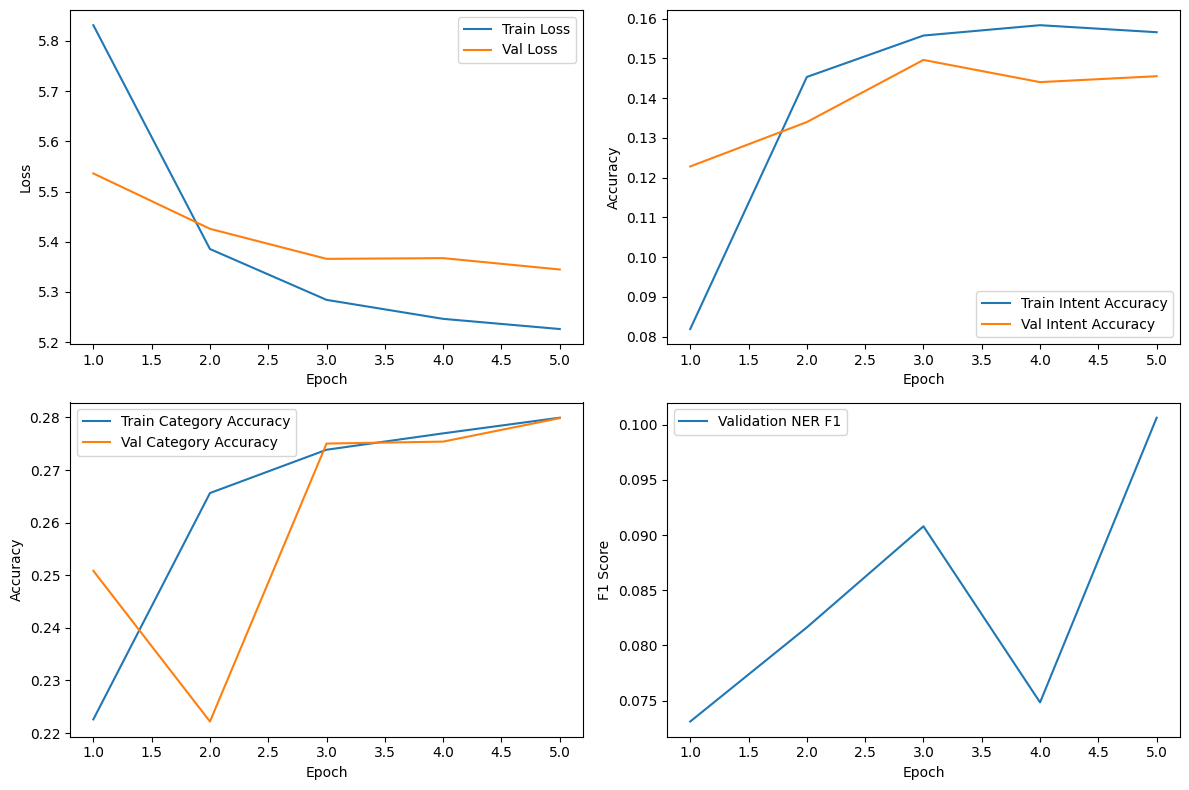

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seqeval.metrics import f1_score, precision_score, recall_score

# Define hyperparameters
batch_size = 8
learning_rate = 5e-5
num_epochs = 5
weight_decay = 0.01

# Define loss functions
loss_fn_intent = CrossEntropyLoss()
loss_fn_category = CrossEntropyLoss()
loss_fn_ner = CrossEntropyLoss(ignore_index=9)  # Ignore padding index

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Custom Training Loop
def custom_train_loop(model, train_dataloader, val_dataloader, optimizer, num_epochs=num_epochs):
    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'train_intent_accuracy': [],
        'val_intent_accuracy': [],
        'train_category_accuracy': [],
        'val_category_accuracy': [],
        'val_ner_f1': []
    }

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        all_train_intent_preds = []
        all_train_intents = []
        all_train_category_preds = []
        all_train_categories = []

        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intents = batch['intents'].to(device)
            categories = batch['categories'].to(device)
            ner_labels = batch['ner_labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            intent_logits, category_logits, ner_logits = model(input_ids, attention_mask)

            # Compute losses
            loss_intent = loss_fn_intent(intent_logits, intents)
            loss_category = loss_fn_category(category_logits, categories)

            # Reshape NER logits and labels
            ner_logits = ner_logits.view(-1, num_ner_labels)
            ner_labels = ner_labels.view(-1)

            # Ensure the labels are padded to match the logits
            if ner_labels.size(0) != ner_logits.size(0):
                pad_length = ner_logits.size(0) - ner_labels.size(0)
                padding = torch.full((pad_length,), 9, dtype=ner_labels.dtype, device=device)
                ner_labels = torch.cat([ner_labels, padding], dim=0)

            loss_ner = loss_fn_ner(ner_logits, ner_labels)

            # Combine losses
            total_loss = loss_intent + loss_category + loss_ner

            # Backward pass
            total_loss.backward()
            optimizer.step()

            total_train_loss += total_loss.item()

            # Collect training predictions and labels
            all_train_intent_preds.extend(torch.argmax(intent_logits, dim=1).cpu().numpy())
            all_train_intents.extend(intents.cpu().numpy())
            all_train_category_preds.extend(torch.argmax(category_logits, dim=1).cpu().numpy())
            all_train_categories.extend(categories.cpu().numpy())

        train_loss = total_train_loss / len(train_dataloader)
        train_intent_accuracy = (np.array(all_train_intent_preds) == np.array(all_train_intents)).mean()
        train_category_accuracy = (np.array(all_train_category_preds) == np.array(all_train_categories)).mean()

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Train Intent Accuracy: {train_intent_accuracy}, Train Category Accuracy: {train_category_accuracy}')

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        all_val_intent_preds = []
        all_val_intents = []
        all_val_category_preds = []
        all_val_categories = []
        all_val_ner_preds = []
        all_val_ner_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                intents = batch['intents'].to(device)
                categories = batch['categories'].to(device)
                ner_labels = batch['ner_labels'].to(device)

                # Forward pass
                intent_logits, category_logits, ner_logits = model(input_ids, attention_mask)

                # Compute losses
                loss_intent = loss_fn_intent(intent_logits, intents)
                loss_category = loss_fn_category(category_logits, categories)

                # Reshape NER logits and labels
                ner_logits = ner_logits.view(-1, num_ner_labels)
                ner_labels = ner_labels.view(-1)

                # Ensure the labels are padded to match the logits
                if ner_labels.size(0) != ner_logits.size(0):
                    pad_length = ner_logits.size(0) - ner_labels.size(0)
                    padding = torch.full((pad_length,), 9, dtype=ner_labels.dtype, device=device)
                    ner_labels = torch.cat([ner_labels, padding], dim=0)

                loss_ner = loss_fn_ner(ner_logits, ner_labels)

                # Combine losses
                total_loss = loss_intent + loss_category + loss_ner

                total_val_loss += total_loss.item()

                # Collect validation predictions and labels
                all_val_intent_preds.extend(torch.argmax(intent_logits, dim=1).cpu().numpy())
                all_val_intents.extend(intents.cpu().numpy())
                all_val_category_preds.extend(torch.argmax(category_logits, dim=1).cpu().numpy())
                all_val_categories.extend(categories.cpu().numpy())

                # Reshape NER predictions and labels back to [batch_size, sequence_length]
                ner_logits = ner_logits.view(batch['input_ids'].size(0), batch['input_ids'].size(1), num_ner_labels)
                ner_labels = ner_labels.view(batch['input_ids'].size(0), batch['input_ids'].size(1))

                all_val_ner_preds.extend(torch.argmax(ner_logits, dim=2).cpu().numpy())
                all_val_ner_labels.extend(ner_labels.cpu().numpy())

        val_loss = total_val_loss / len(val_dataloader)
        val_intent_accuracy = (np.array(all_val_intent_preds) == np.array(all_val_intents)).mean()
        val_category_accuracy = (np.array(all_val_category_preds) == np.array(all_val_categories)).mean()

        # Convert predictions and labels to list of lists
        # Inside your validation loop, replace the current conversion with:
        ner_predictions_list = []
        ner_labels_list = []

        for pred, label, mask in zip(all_val_ner_preds, all_val_ner_labels, batch['attention_mask'].cpu().numpy()):
            # Use attention mask to get actual sequence length
            seq_len = sum(mask)

            # Convert IDs to tags and remove padding
            pred_tags = [list(tag_to_id.keys())[id] for id in pred[:seq_len] if id != 9]
            label_tags = [list(tag_to_id.keys())[id] for id in label[:seq_len] if id != 9]

            ner_predictions_list.append(pred_tags)
            ner_labels_list.append(label_tags)

        # Debug prints to check shapes
        print(f"NER Predictions List: {ner_predictions_list[:2]}")
        print(f"NER Labels List: {ner_labels_list[:2]}")

        # Inside the validation loop after collecting all_val_ner_preds and all_val_ner_labels:

        ner_predictions_list = []
        ner_labels_list = []

        for pred_seq, label_seq in zip(all_val_ner_preds, all_val_ner_labels):
            pred_tags = []
            label_tags = []
            for p, l in zip(pred_seq, label_seq):
                if l != 9:  # 9 is the padding index; use your actual padding index if different
                    pred_tags.append(list(tag_to_id.keys())[p])
                    label_tags.append(list(tag_to_id.keys())[l])
            ner_predictions_list.append(pred_tags)
            ner_labels_list.append(label_tags)

        # Now compute metrics
        val_ner_f1 = f1_score(ner_labels_list, ner_predictions_list)  # Note: order is (true, pred)

        # Add these prints before calculating F1 score
        print(f"Number of sequences: {len(ner_predictions_list)}")
        print(f"Average sequence length (predictions): {np.mean([len(x) for x in ner_predictions_list])}")
        print(f"Average sequence length (labels): {np.mean([len(x) for x in ner_labels_list])}")

        # Calculate F1 score for NER
        # val_ner_f1 = f1_score(ner_predictions_list, ner_labels_list)
        val_ner_precision = precision_score(ner_predictions_list, ner_labels_list)
        val_ner_recall = recall_score(ner_predictions_list, ner_labels_list)

        print(f'Validation Loss: {val_loss}, Validation Intent Accuracy: {val_intent_accuracy}, Validation Category Accuracy: {val_category_accuracy}, Validation NER F1: {val_ner_f1}')

        # Save the metrics to the history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_intent_accuracy'].append(train_intent_accuracy)
        history['val_intent_accuracy'].append(val_intent_accuracy)
        history['train_category_accuracy'].append(train_category_accuracy)
        history['val_category_accuracy'].append(val_category_accuracy)
        history['val_ner_f1'].append(val_ner_f1)

    # Save the history to a CSV file
    history_df = pd.DataFrame(history)
    history_df.to_csv('training_history.csv', index=False)

    # Plot the metrics
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history['epoch'], history['train_intent_accuracy'], label='Train Intent Accuracy')
    plt.plot(history['epoch'], history['val_intent_accuracy'], label='Val Intent Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history['epoch'], history['train_category_accuracy'], label='Train Category Accuracy')
    plt.plot(history['epoch'], history['val_category_accuracy'], label='Val Category Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(history['epoch'], history['val_ner_f1'], label='Validation NER F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define DataLoaders with the specified batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train the model
custom_train_loop(model, train_dataloader, val_dataloader, optimizer)